## Build, train, and test and model

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['food-101']


In [2]:
from fastai import *
from fastai.vision import *
from fastai.callbacks import *

In [3]:
path = Path("../input/food-101/food-101")
path.ls()

[PosixPath('../input/food-101/food-101/images'),
 PosixPath('../input/food-101/food-101/meta'),
 PosixPath('../input/food-101/food-101/.DS_Store'),
 PosixPath('../input/food-101/food-101/README.txt'),
 PosixPath('../input/food-101/food-101/license_agreement.txt')]

### Prepare data

In [4]:
train_df = pd.read_csv(path/'meta/train.txt', header=None)
test_df = pd.read_csv(path/'meta/test.txt', header=None)

train_df['valid']=0
test_df['valid']=1

train_df.columns = ['name', 'valid']
test_df.columns = ['name', 'valid']

train_df['label'] = train_df.name.apply(lambda o: Path(o).parts[0])
test_df['label'] = test_df.name.apply(lambda o: Path(o).parts[0])

df = train_df.append(test_df)
print(len(df))
df.head()

101000


,name,valid,label
0,apple_pie/1005649,0,apple_pie
1,apple_pie/1014775,0,apple_pie
2,apple_pie/1026328,0,apple_pie
3,apple_pie/1028787,0,apple_pie
4,apple_pie/1043283,0,apple_pie


In [5]:
il = ImageList.from_df(df, path/'images', suffix=".jpg"); il

ImageList (101000 items)
Image (3, 512, 308),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
Path: ../input/food-101/food-101/images

In [6]:
# il = il.use_partial_data(sample_pct=0.01)

In [7]:
s = il.split_from_df(col=1); s

ItemLists;

Train: ImageList (75750 items)
Image (3, 512, 308),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
Path: ../input/food-101/food-101/images;

Valid: ImageList (25250 items)
Image (3, 512, 512),Image (3, 512, 384),Image (3, 512, 384),Image (3, 512, 382),Image (3, 342, 512)
Path: ../input/food-101/food-101/images;

Test: None

In [8]:
src = s.label_from_df(cols=2); src

LabelLists;

Train: LabelList (75750 items)
x: ImageList
Image (3, 512, 308),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: CategoryList
apple_pie,apple_pie,apple_pie,apple_pie,apple_pie
Path: ../input/food-101/food-101/images;

Valid: LabelList (25250 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 384),Image (3, 512, 384),Image (3, 512, 382),Image (3, 342, 512)
y: CategoryList
apple_pie,apple_pie,apple_pie,apple_pie,apple_pie
Path: ../input/food-101/food-101/images;

Test: None

### Data Augmentation 

In [9]:
xtra = [brightness(change=(0.40,0.63), p=0.75), contrast(scale=(0.95,1.1), p=0.75), crop(size=224, row_pct=(0.3,0.7), col_pct=(0.3,0.7)), 
        squish(scale=(0.80,1.2)), tilt(direction=(0,3), magnitude=(-0.3,0.3)), skew(direction=(0,3), magnitude=(-0.2,0.2))]
tfms = get_transforms(max_rotate=30., max_warp=0.3, max_lighting=None, p_affine=0.75, xtra_tfms= xtra)

In [10]:
data = (src.transform(tfms=tfms, size=224)
        .databunch(bs=64)
        .normalize(imagenet_stats))

In [11]:
learn = cnn_learner(data, models.resnet50, metrics=[accuracy, top_k_accuracy], #pretrained=True, 
                    ps=0.5, wd=0.05,
                    model_dir = '/kaggle/working/Models', 
                    callback_fns=[partial(CSVLogger, filename='/kaggle/working/Models/history1', append=False)]).mixup()

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /tmp/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:10<00:00, 9320116.87it/s] 


In [12]:
learn.to_fp16();

In [13]:
# learn.lr_find()

In [14]:
# learn.recorder.plot()

In [15]:
# val = learn.data.valid_dl

In [16]:
# learn.data.valid_dl = None

### Training


In [17]:
learn.fit_one_cycle(2, max_lr=1e-2)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,3.028607,1.975757,0.506297,0.791010,28:40


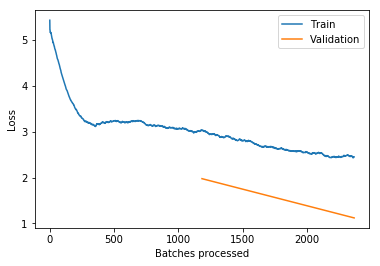

In [18]:
learn.recorder.plot_losses()

In [19]:
learn.unfreeze()

In [20]:
# learn.lr_find()

In [21]:
# learn.recorder.plot()

In [22]:
# learn.fit_one_cycle(1, max_lr=slice(3e-6,3e-5))

In [23]:
# learn.recorder.plot_losses()

In [24]:
learn.fit_one_cycle(15, max_lr=slice(3e-5,3e-3), 
                    callbacks=[SaveModelCallback(learn, every='improvement', monitor='valid_loss', mode='min', name='best')])

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,2.367840,1.012776,0.743564,0.931327,26:53
1,2.385297,1.106668,0.712832,0.919446,27:17


Better model found at epoch 0 with valid_loss value: 1.0127756595611572.


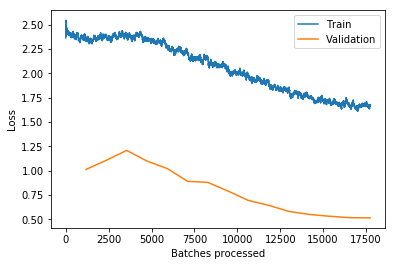

In [25]:
learn.recorder.plot_losses()

In [26]:
# learn.data.valid_dl = val

In [27]:
# preds = learn.TTA()

In [28]:
# accuracy(*preds), top_k_accuracy(*preds)

In [29]:
# learn.validate(learn.data.train_dl)

In [30]:
# learn.validate(learn.data.valid_dl)

### Results

In [31]:
learn.csv_logger.read_logged_file()

,epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,0,2.367840,1.012776,0.743564,0.931327,26:53
1,1,2.385297,1.106668,0.712832,0.919446,27:17
2,2,2.406073,1.207989,0.689030,0.905901,27:39
3,3,2.370699,1.098189,0.719525,0.921069,27:43
4,4,2.285247,1.020955,0.731446,0.929584,27:33
5,5,2.208523,0.889818,0.767010,0.943247,27:40
6,6,2.158288,0.878435,0.768040,0.942020,27:38
7,7,2.071015,0.789108,0.792753,0.951485,27:44
8,8,1.983948,0.692767,0.819168,0.960198,27:47
9,9,1.925350,0.642464,0.831564,0.965307,27:48


In [32]:
learn.save(file='food-101-res50-224-nb-15-Mix-best',return_path=True)

PosixPath('/kaggle/working/Models/food-101-res50-224-nb-15-Mix-best.pth')

**86.3% Top-1 accuracy, 97.4% Top-5 accuracy**